In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script> so much code! click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy as sp
import pandas as pd
import seawater
import datetime as dt
""
from salishsea_tools import (
    nc_tools,
    viz_tools,
    geo_tools,
    tidetools
)

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-whitegrid')
import netCDF4 as nc
import pickle
import cmocean as cm
import glob
import sys
sys.path.append('/data/tjarniko/mocsy')
import mocsy

#from matplotlib import reload
import arrow
import gsw
import time

%matplotlib inline

plt.rcParams.update({'font.size': 20,
                     'xtick.labelsize' : 20,
                     'ytick.labelsize' : 20})



In [4]:

import BC_helper_methods as hm
import importlib
importlib.reload(hm)

<module 'BC_helper_methods' from '/ocean/tjarniko/MEOPAR/analysis_tereza/notebooks/RIVER_PAPER/future_pilot/BC_helper_methods.py'>

In [5]:
def calc_preind_co2_AOU_method(arrowdate, obs_year, target_year, scen):
    import numpy as np
    import netCDF4 as nc
    import gsw
    
    test_LO = hm.load_nc(arrowdate)
    
    tdate = arrowdate
    yy = tdate.format('YYYY')
    mm = tdate.format('MM')
    dd = tdate.format('DD')
    ymd = f'y{yy}m{mm}d{dd}'
    #open dataset & retrieve relevant variables, calculate potential density

    zlevels = (test_LO['deptht'][:])
    sal = test_LO['vosaline'][0,:,0,:]
    temp = test_LO['votemper'][0,:,0,:]
    sigma0 = gsw.sigma0(sal,temp)
    DIC = test_LO['DIC'][0,:,0,:]
    TA = test_LO['TA'][0,:,0,:]
    O2 = test_LO['OXY'][0,:,0,:]
    depth_this = np.zeros_like(TA)
    zeros = np.zeros_like(TA)
    #depth_this - array of depths of same shape as DIC
    for i in range(0,950):
        depth_this[:,i] = zlevels
 
 ### GET AGE AND WATERMASS WITNESSED CO2   
    #calculate pycnal's last surfacing, according to exp function
    #found using cfc ages
    params0 = 0.1301889490932413
    params1 = 3.8509914822057825
    params2 = 8.301166081413104 #change to 2015 since model year is 2015


    water_age = (params0 *np.exp(-params1*(25.15-sigma0))+params2)
    # year_watermass_at_surface = int(targetyear - age)
    # watermass_witnessed_co2_obs = int(hm.co2_from_year(scen,year_watermass_at_surface))

    #get witnessed co2 both of the present day water parcel and the target year water parcel
    obs_year_ar = np.zeros_like(water_age)
    obs_year_ar[:] = obs_year
    
    target_year_ar = np.zeros_like(water_age)
    target_year_ar[:] = target_year
    
    year_watermass_at_surface = (obs_year_ar - water_age).astype(int)
    watermass_witnessed_co2_obs = hm.co2_from_year(scen,year_watermass_at_surface)
    print(np.min(watermass_witnessed_co2_obs))
    print(np.shape(watermass_witnessed_co2_obs))
    watermass_witnessed_co2_target = \
    hm.co2_from_year(scen,year_watermass_at_surface+(target_year_ar-obs_year_ar))

###GET AOU
#(1) estimate AOU on 26 (assoc with water parcel with DIC_{w,2019,26,jdf})
# = f(O2_{w,2019,26,jdf},S_{w,2019,26,jdf},T_{w,2019,26,jdf}, P_{w,2019,26,jdf})
#(P is there to determine T when last at surface - I'll call it preT next)
    AOU_stoich = hm.get_AOU_stoich(sal,temp,O2,sigma0,water_age)

 ### GET PREFORMED DIC        
    obs_preformed_dic = DIC - AOU_stoich

#### get preformed pco2 and target year preformed pco2
    pHr, OmAr, pco2r = hm.oned_moxy(sal, temp, obs_preformed_dic, TA, 1, np.zeros_like(sal))
    obsyear_pref_pco2 = pco2r
    diseqPCO2 = obsyear_pref_pco2 - watermass_witnessed_co2_obs
    targetyear_pref_pco2 = watermass_witnessed_co2_target + diseqPCO2

    print('calculating target year preformed DIC')    
    target_preformed_dic = np.zeros_like(DIC)
    target_preformed_dic_r = np.ravel(target_preformed_dic)
    targetyear_pref_pco2_r = np.ravel(targetyear_pref_pco2)
    depth_r = np.ravel(depth_this)
    sal_r = np.ravel(sal)
    temp_r = np.ravel(temp)
    TA_r = np.ravel(TA)
    zeros_r = np.zeros_like(TA_r)
    sigma0_r = np.ravel(sigma0)
 
    start = time.time()
    
    for i in range(0,len(TA_r)):
        if i%(950*5) == 0:
            print(f'level: {i/(950*5)}')
        ### the surface needs better handling    
        if sigma0_r[i] < 25.0:
            target_preformed_dic_r[i] = 9999
        #### the bottom can be actually taken from the cell right above it, no need to do this painful calculation
        if depth_r[i] > 330:
            target_preformed_dic_r[i] = 6666
        else: 
            t_dic = hm.find_DIC_corresp_to_pco2(sal_r[i], temp_r[i], targetyear_pref_pco2_r[i], TA_r[i], 1, 0)
            target_preformed_dic_r[i] = t_dic
    
    
    print('seconds taken at the hard part')
    print(time.time()-start)
    
#     deltaDIC = obs_preformed_dic - target_preformed_dic
            
#     print('max deltaDIC: '+str(np.max(deltaDIC)) + ', min deltaDIC: '+ str(np.min(deltaDIC)))

#     final_target_DIC = DIC - deltaDIC
    
    ## the top and bottom can be dealt with differently

    DIC_r = np.ravel(DIC)
    obs_preformed_dic_r = np.ravel(obs_preformed_dic)
    deltaDIC_r = obs_preformed_dic_r - target_preformed_dic_r
    final_target_DIC_r = DIC_r - deltaDIC_r
    
    for i in range(0,len(TA_r)):
        if sigma0_r[i] < 25.0:
            deltaDIC_r[i] = 9999
            obs_preformed_dic_r[i] = 9999
            target_preformed_dic_r[i] = 9999
            final_target_DIC_r[i] = 9999
            
        if depth_r[i] > 330:    
            deltaDIC_r[i] = 6666
            obs_preformed_dic_r[i] = 6666
            target_preformed_dic_r[i] = 6666
            final_target_DIC_r[i] = 6666

    deltaDIC = deltaDIC_r.reshape(40,950)
    obs_preformed_dic = obs_preformed_dic_r.reshape(40,950)
    target_preformed_dic = target_preformed_dic_r.reshape(40,950)
    final_target_DIC = final_target_DIC_r.reshape(40,950)
    #target_preformed_dic = target_preformed_dic_r.reshape(40,950)
            
#     target_year_ar = np.zeros_like(final_target_DIC)
#     target_year_ar[:] = target_year
    
    f = nc.Dataset(f'./JdF_future_DIC/LO_TY_{target_year}_scen_{scen}_{ymd}_DIC_nosurfnodeep.nc','w', format='NETCDF4') #'w' stands for write
    g = f.createGroup('preindustrial_DIC')
    g.createDimension('xval', 950)
    g.createDimension('depth', 40)
    g.createDimension('single', 1)
    
    ts = g.createVariable('sigma0','f4',('depth','xval'))
    ts[:] = sigma0

    ts2 = g.createVariable('water_age','f4',('depth','xval'))
    ts2[:] = water_age

    ts2a = g.createVariable('target_year','f4',('single'))
    ts2a[:] = target_year  

#     ts3 = g.createVariable('watermass_witnessed_co2_obs','f4',('depth','xval'))
#     ts3[:] = watermass_witnessed_co2_obs

#     ts3a = g.createVariable('watermass_witnessed_co2_target','f4',('depth','xval'))
#     ts3a[:] = watermass_witnessed_co2_target
    
    ts4 = g.createVariable('AOU_stoich','f4',('depth','xval'))
    ts4[:] = AOU_stoich
    
    ts5 = g.createVariable('obsyear_pref_pco2','f4',('depth','xval'))
    ts5[:] = obsyear_pref_pco2
    ts5a = g.createVariable('targetyear_pref_pco2','f4',('depth','xval'))
    ts5a[:] = targetyear_pref_pco2
    
    ts5b = g.createVariable('obsyear_pref_dic','f4',('depth','xval'))
    ts5b[:] = obs_preformed_dic
    ts5c = g.createVariable('targetyear_pref_dic','f4',('depth','xval'))
    ts5c[:] = target_preformed_dic
    
    ts6 = g.createVariable('final_target_DIC','f4',('depth','xval'))
    ts6[:] = final_target_DIC

    f.close()



In [6]:
# ymd = 'y2017m01d06'
# tstr = f'/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_{ymd}.nc'

# test_LO = nc.Dataset(tstr)

# zlevels = (test_LO['deptht'][:])
# sal = test_LO['vosaline'][0,:,0,:]
# temp = test_LO['votemper'][0,:,0,:]
# sigma0 = gsw.sigma0(sal,temp)
# DIC = test_LO['DIC'][0,:,0,:]
# TA = test_LO['TA'][0,:,0,:]
# O2 = test_LO['OXY'][0,:,0,:]
# depth_this = np.zeros_like(TA)
# zeros = np.zeros_like(TA)
# #depth_this - array of depths of same shape as DIC
# for i in range(0,950):
#     depth_this[:,i] = zlevels

# tshal = 34
# print(w['deptht'][tshal:-1])
# print()
# print(w['TA'][0,tshal:-1,0,50])
# print()
# print(w['TA'][0,tshal:-1,0,90])

# print(w['deptht'][35])
# for i in range (0,95):
#     print(w['votemper'][0,35,0,i]-w['votemper'][0,34,0,i])

In [7]:
import time
import BC_helper_methods as hm
import importlib
importlib.reload(hm)


start = '2017-01-01'
start_run = arrow.get(start)

start = time.time()
calc_preind_co2_AOU_method(start_run, 2017, 2050, '2_4pt5')
print('seconds taken')
print(time.time()-start)

2017-01-01T00:00:00+00:00
341
(40, 950)
calculating target year preformed DIC
level: 0.0


KeyboardInterrupt: 

In [8]:
def deltaDIC_method()

SyntaxError: invalid syntax (<ipython-input-8-49a9c3d84a4c>, line 1)

In [9]:
w = nc.Dataset('./JdF_future_DIC/LO_TY_2050_scen_2_4pt5_y2017m01d01_DIC_nosurfnodeep.nc')
print(w['preindustrial_DIC'])

<class 'netCDF4._netCDF4.Group'>
group /preindustrial_DIC:
    dimensions(sizes): xval(950), depth(40), single(1)
    variables(dimensions): float32 sigma0(depth,xval), float32 water_age(depth,xval), float32 target_year(single), float32 AOU_stoich(depth,xval), float32 obsyear_pref_pco2(depth,xval), float32 targetyear_pref_pco2(depth,xval), float32 obsyear_pref_dic(depth,xval), float32 targetyear_pref_dic(depth,xval), float32 final_target_DIC(depth,xval)
    groups: 



/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if sys.path[0] == '':
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3. 

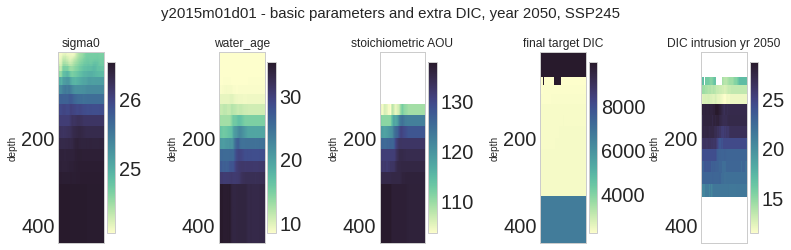

In [11]:
tcmap = cm.cm.deep
cmap = tcmap
test_LO = nc.Dataset('/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_y2018m01d01.nc')
zlevels = (test_LO['deptht'][:])

fig = plt.figure(figsize=(11,3.5))

ax = fig.add_subplot(1,5,1)
section_slice = np.arange(0, 95)
sd = (w['preindustrial_DIC']['sigma0'][:,0:95])
tplt = np.ma.masked_values(sd,0)
mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,:], cmap = tcmap)
cbar = fig.colorbar(mesh, ax=ax)
ax.invert_yaxis()
plt.title('sigma0') 
ax.set_ylabel('depth')
ax.set_xticklabels([])

ax = fig.add_subplot(1,5,2)
section_slice = np.arange(0, 95)
sd = (w['preindustrial_DIC']['water_age'][:,0:95])
tplt = np.ma.masked_values(sd,0)
mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,:], cmap = tcmap)
cbar = fig.colorbar(mesh, ax=ax)
ax.invert_yaxis()
plt.title('water_age') 
ax.set_ylabel('depth')
ax.set_xticklabels([])


ax = fig.add_subplot(1,5,3)
section_slice = np.arange(0, 95)
sd = (w['preindustrial_DIC']['AOU_stoich'][:,0:95])
tplt = np.ma.masked_values(sd,0)
mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,:], cmap = tcmap)
cbar = fig.colorbar(mesh, ax=ax)
ax.invert_yaxis()
plt.title('stoichiometric AOU') 
ax.set_ylabel('depth')
ax.set_xticklabels([])

ax = fig.add_subplot(1,5,4)
section_slice = np.arange(0, 95)
sd = (w['preindustrial_DIC']['final_target_DIC'][:,0:95])
tplt = np.ma.masked_values(sd,0)
mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,:], cmap = tcmap)
cbar = fig.colorbar(mesh, ax=ax)
ax.invert_yaxis()
plt.title('final target DIC') 
ax.set_ylabel('depth')
ax.set_xticklabels([])


ax = fig.add_subplot(1,5,5)
section_slice = np.arange(0, 95)
sd = (w['preindustrial_DIC']['targetyear_pref_dic'][:,0:95]-\
     w['preindustrial_DIC']['obsyear_pref_dic'][:,0:95])
tplt = np.ma.masked_values(sd,0)
mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,:], cmap = tcmap)
cbar = fig.colorbar(mesh, ax=ax)
ax.invert_yaxis()
plt.title('DIC intrusion yr 2050') 
ax.set_ylabel('depth')
ax.set_xticklabels([])
        
plt.suptitle('y2015m01d01 - basic parameters and extra DIC, year 2050, SSP245 ', fontsize = 15)
plt.tight_layout()

In [ ]:
q = w['preindustrial_DIC']['AOU_stoich'][:,0:95]
print(q)